In [1]:
#######################################################################
# Loading data
#######################################################################

using MatrixNetworks
using Distributions
using Gadfly
using Clustering
using NPZ
using BenchmarkTools, Compat
using DelimitedFiles
using SparseArrays
using Printf
using LinearAlgebra

m = readdlm("Data/PowerEU/ElistPowerEU.txt");
dim = size(m,1);

M_int = zeros(Int64,dim,2);
for i =1:dim
	for j=1:2
		M_int[i,j] = Int64(m[i,j]);
	end
end

N = maximum([maximum(M_int[:,1]),maximum(M_int[:,2])]);

A0 =spzeros(N,N);
A0 = sparse(M_int[:,1],M_int[:,2],vec(ones(Int64,dim,1)),N,N);
A0 = A0+A0';
A,p = largest_component(A0);

A0=0;p=0;m =0;

#######################################################################

In [2]:
#######################################################################
# First call to compile the functions
#######################################################################
print("------------ First Run for Compilation ------------- \n")

include("Algo/SphereEmbedCluster.jl")

n_it_PPM = 2;
t = 1e-06;
n_clusters = 2;
n_it_Kmeans = 3;
shape = "Ellipsoidal"; #shape = "Spherical"
r0 = 20;

n_updates = 10;
sig,community =  SphereEmbedCluster(A,n_it_PPM,t, n_clusters,n_it_Kmeans,n_updates,shape,r0);

	print("\n------------ DONE: TEST OK ------------- \n")
#######################################################################

------------ First Run for Compilation ------------- 

 ------- Acc Projected Power Iteration -------
The iteration did not converge after 2 iterations
The relative difference between the last objective values 0.008496 
  0.087162 seconds (35.93 k allocations: 10.779 MiB)
OK 
 -------------- Clustering ------- 
Number of updates: 0
Number of communities: 2
Modularity: 0.12345104709590839
 -------------------------------------------- 
The squared singular values divided by N : 
[0.966982, 0.00444459, 0.00327285, 0.00260426, 0.00236542, 0.00208068, 0.00190456, 0.00171008, 0.00162926, 0.00161887, 0.00161074, 0.00155117, 0.0014095, 0.00127998, 0.00121628, 0.00111296, 0.000951436, 0.000847956, 0.000739637, 0.000667987]

------------ DONE: TEST OK ------------- 


In [3]:
#######################################################################
# Second call to compute the embedding and the best partition
#######################################################################
n_it_PPM = 30000;
t = 1e-10;
n_clusters = 100;
n_it_Kmeans = 1000;
n_updates = 100;

shape = "Ellipsoidal";
#shape = "Spherical"
r0 = 50;
community = zeros(N,1);
sig,community =  @time SphereEmbedCluster(A,n_it_PPM,t, n_clusters,n_it_Kmeans,n_updates,shape,r0)

print("\n------------ DONE ------------- \n")
#######################################################################


 ------- Acc Projected Power Iteration -------
The iteration has become stationary after 467 iterations
  2.988316 seconds (27.79 k allocations: 4.362 GiB, 7.07% gc time)
OK 
 -------------- Clustering ------- 
Number of updates: 9
Number of communities: 42
Modularity: 0.9119870634499547
 -------------------------------------------- 
The squared singular values divided by N : 
[0.541264, 0.343204, 0.113721, 0.0013741, 0.000166041, 0.000136986, 7.2986e-5, 1.76938e-5, 1.18139e-5, 7.75829e-6, 6.15288e-6, 4.90228e-6, 3.34454e-6, 2.27839e-6, 1.92898e-6, 1.2755e-6, 1.11722e-6, 8.21836e-7, 4.04691e-7, 2.10891e-7, 1.57289e-7, 1.26489e-7, 8.94171e-8, 8.00258e-8, 6.32891e-8, 5.26525e-8, 4.24988e-8, 3.64507e-8, 2.16685e-8, 1.96126e-8, 1.3397e-8, 1.28721e-8, 1.08964e-8, 7.79196e-9, 5.68914e-9, 5.11636e-9, 3.51445e-9, 2.90858e-9, 2.03437e-9, 1.1736e-9, 7.02754e-10, 5.26812e-10, 3.48315e-10, 1.83165e-10, 1.62567e-10, 1.03055e-10, 6.72092e-11, 4.87042e-11, 3.58733e-11, 3.1946e-11]
 19.777126 seconds

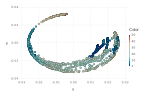

In [4]:
#######################################################################
# Plotting
#######################################################################
# The effetive dimension is 3
# One 2D-projection
plot(x=sig[1,:],y=sig[2,:], color = community)
# the colors are the retreived communities

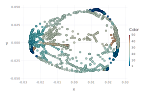

In [7]:
#######################################################################
# Plotting
#######################################################################
# another 2D-projection
plot(x=sig[1,:],y=sig[3,:], color = community)

In [8]:
#######################################################################
# Post-processing
#######################################################################
print("PostProcessing minimalist ");print(" \n")

include("Algo/ConComponentsCommunities.jl")
N = length(community);
community_n = zeros(Int64,N,1);
community_n = ConComponentsCommunities(A,community);

while countnz(community_n)!==N 
    id_zeros = find(community_n.==0);
    nb_zeros = length(id_zeros);
    for n_i=1:nb_zeros
        i =id_zeros[n_i];
    
        if community_n[i]==0
            nearest_nb = find(A[i,:].!==0);
            nnb = length(nearest_nb);
            j = 1;
            ok = 0;
            while j<= nnb && ok==0                
                if community_n[nearest_nb[j]]!==0
                    community_n[i]=community_n[nearest_nb[j]];
                    ok=1;
                end
                j += 1;
            end
        end
        
    end
end

d = sum(A,2);
s = sum(d);
n_c = length(unique(community_n));
H_lab = sparse(1:N,community_n,vec(ones(Int64,N,1)),N,n_c);
Q_best = (1/s)*(trace(H_lab'*A*H_lab)-(norm(d'*H_lab,2)^2)/s);
print("Modularity: ");print(Q_best);print(" \n")
#######################################################################

PostProcessing minimalist  
Modularity: 0.9128414375331606 
